## Dataset Setup

In [1]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset
from keras.models import load_model

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

Running on Python Version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
Using Tensorflow Version: 2.6.2
Using GPU at: /device:GPU:0 (of 1 available)


In [2]:
# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/Mluckydwyer/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

## Working with the Dataset

In [3]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)
with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
        
class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

In [4]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the class
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Validation: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Dataset Info: tfds.core.DatasetInfo(
    name='tiny_imagenet_dataset',
    full_name='tiny_imagenet_dataset/0.2.0',
    description="""
    Tiny ImageNet Challenge is a similar challenge as ImageNet with a smaller dataset but
                             less image classes. It contains 200 image classes, a training
                             dataset of 100, 000 images, a validation dataset of 10, 000
                             images, and a test dataset of 10, 000 images. All images are
                             of size 64×64.
    """,
    homepage='http

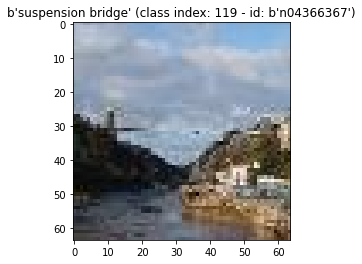

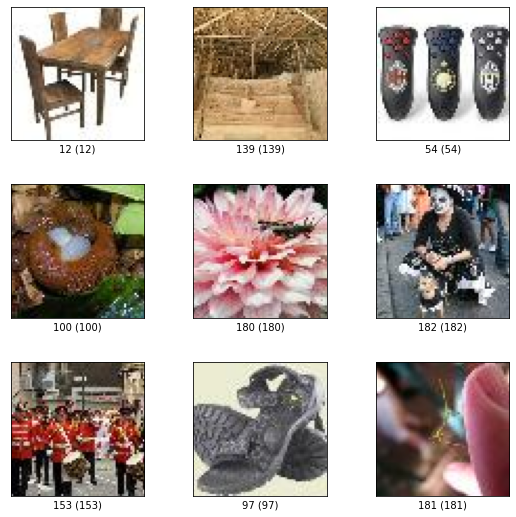

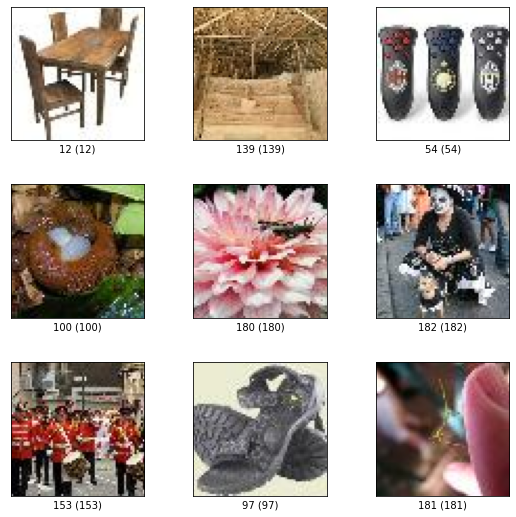

In [5]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory required: 12288 (Bytes)
Label: b'computer keyboard, keypad' (class index: 26 - id: b'n03085013')

--- Image 1 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory required: 12288 (Bytes)
Label: b'gasmask, respirator, gas helmet' (class index: 83 - id: b'n03424325')

--- Image 2 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory required: 12288 (Bytes)
Label: b'brain coral' (class index: 164 - id: b'n01917289')


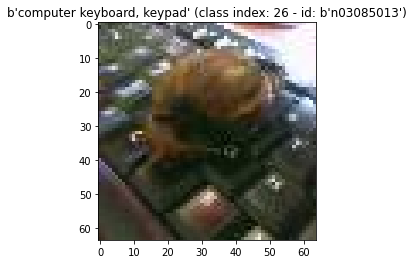

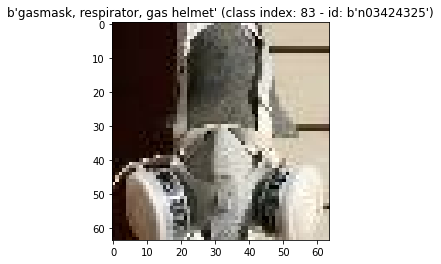

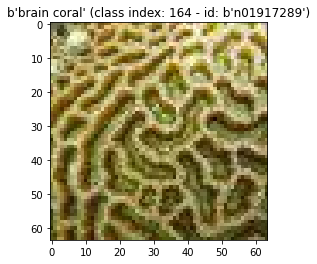

In [6]:
# TODO: Print and visualize three inputs from the validation set
#     : Print the storage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.take(3)):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    data_type = image.dtype # Supposed storage data type
    image_dimensions = image.shape # Supposed image shape
    dtype_size = image.dtype.size
    mem_per_element = image_dimensions.num_elements()
    memory_required = dtype_size * mem_per_element

    print(f'\n--- Image {index} ---')
    print(f"Storage Data Type: {data_type}") # Print out the storage data type
    print(f"Image Dimensions: {image_dimensions}") # Print and note the dimensions for the current image
    print(f"Memory required: {memory_required} (Bytes)") # Print the memory required to store each image
    img_info(img_data)
    

In [7]:
# TODO: Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):    
    img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')
    
    # TODO: Your Code Here
    image_data = img_data["image"].numpy() # Grabs the numerical image data from the img_data
    stringed_image_data = image_data.flatten() # Flattens the 4D array into byte array [1D]
    img_file.write(stringed_image_data.tobytes()) # Writes to the file in proper formatting

    # print(stringed_image_data.shape) # Used to test we are acquiring 12288 1D array of bytes
  
    img_file.close()

    # Write the image metadata for reference later
    class_str = img_class(img_data)
    metadata_file.write(f'{index}\t\t{img_data["image"].shape}\t\t{class_str}\n')
metadata_file.close()

## Model Setup

In [8]:
# TODO: Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/dwyer/482/dev/CNN_TinyImageNet_2.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet_2.h5")

# TODO: Your Code Here
model = tf.keras.models.load_model(model_path) # I believe this should do the trick

# TODO: Print a summary of the model
print(model.summary())
# NOTE: https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

# Running Infrence

Label: [b'brain coral'] (class index: [164] - id: [b'n01917289'])
Raw 200 Class Weighted Prediction:
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.000

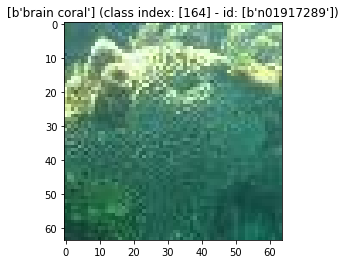

In [9]:
# Running infrence on our model
# We can run an infrence of our model by doing the following (we are doing batches of 1 here)
for example in ds_train.batch(1).take(1):
    img_info(example)
    
    # Make a prediction
    pred = model.predict(example["image"])
    print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx][0]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

Label: b'computer keyboard, keypad' (class index: 26 - id: b'n03085013')
Best Guess [class index]: ['abacus'] [63]
Best Guess Confidence (percent / 1.0): [1.]
Top 15 Guesses (class index): ['[ [63]', '[ [111]', '[ [4]', '[ [190]', '[ [188]', '[ [0]', '[ [1]', '[ [2]', '[ [3]', '[ [5]', '[ [6]', '[ [7]', '[ [8]', '[ [9]', '[ [10]']
Top 15 Guesses Confidence (percent / 1.0): [[1.0000000e+00 1.0913629e-26 3.7863541e-34 1.4824005e-35 3.3100270e-38
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
Label: b'gasmask, respirator, gas helmet' (class index: 83 - id: b'n03424325')
Best Guess [class index]: ['reel'] [1]
Best Guess Confidence (percent / 1.0): [1.]
Top 15 Guesses (class index): ['[ [1]', '[ [62]', '[ [74]', '[ [0]', '[ [2]', '[ [3]', '[ [4]', '[ [5]', '[ [6]', '[ [7]', '[ [8]', '[ [9]', '[ [10]', '[ [11]', '[ [12]']
Top 15 Guesses Confidence (percent / 1.0): [[1.0000000e+00 2.7726262e-29 

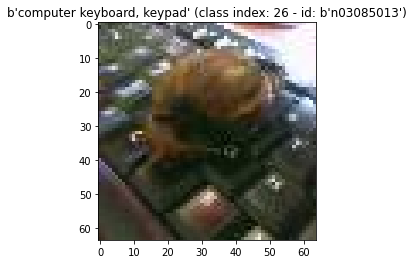

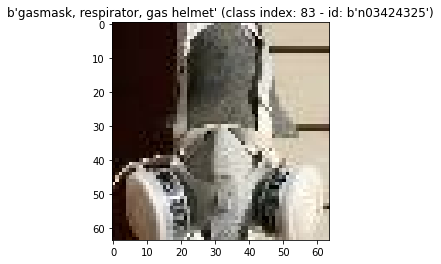

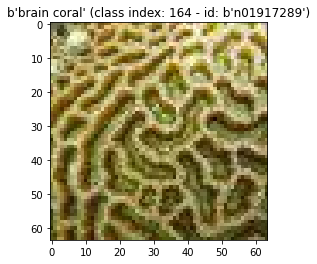

In [10]:
# TODO: Run infrence for our previous 3 sample images

# TODO: Your Code Here
for img_data in sample_imgs: # Start a for-loop in order to iterate through our sample images
    img_info(img_data)


    prediction = model.predict(np.expand_dims(img_data["image"], axis=0))
    
    best_guess = tf.math.argmax(prediction, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {prediction[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(prediction, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx][0]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

In [11]:
# TODO: Calculate the Top-1, Top-5, and Top-10 Accuracy of the validation dataset
total = acc_top1 = acc_top5 = acc_top10 = 0

# TODO: Your Code Here
for img_data in ds_val.batch(32): # Just creating another for loop in order to show how these examples will work.
    
    prediction = model.predict(img_data["image"].numpy())

    top_1 = tf.math.top_k(prediction, k=1).indices
    top_5 = tf.math.top_k(prediction, k=5).indices
    top_10 = tf.math.top_k(prediction, k=10).indices

    for i, img_label in enumerate(img_data['label'].numpy()):
        if img_label in top_1[i]:
            acc_top1 += 1
        if img_label in top_5[i]:
            acc_top5 += 1
        if img_label in top_10[i]:
            acc_top10 += 1

    total += 32


acc_top10 /= (total / 100) # Dividing by 1/100 multiplies :D
acc_top5 /= (total / 100)
acc_top1 /= (total / 100)

print("Accuracy (Top 10):", acc_top10, ",Accuracy (Top 5): ", acc_top5, ", Accuracy (Top 1): ", acc_top1)
    

Accuracy (Top 10): 15.225638977635784 ,Accuracy (Top 5):  12.649760383386582 , Accuracy (Top 1):  6.968849840255591


In [12]:
# TODO: Print all of the possible classes of the dataset

train_classes = val_classes = 0

# TODO: Your Code Here
for image in ds_val:
    #class_name = image['metadata']['label_name'].numpy()
    val_classes += 1

# COMMENTED OUT FOR SUBMISSION

for image in ds_train:
#     class_name = image['metadata']['label_name'].numpy()
    train_classes += 1
    
print(class_names)
print("NUMBER OF CLASSES IN VAL DATASET: ", val_classes)
print("NUMBER OF CLASSES IN TRAIN DATASET", train_classes)




["['Egyptian cat']", "['reel']", "['volleyball']", "['rocking chair', 'rocker']", "['lemon']", "['bullfrog', 'Rana catesbeiana']", "['basketball']", "['cliff', 'drop', 'drop-off']", "['espresso']", '[\'plunger\', "plumber\'s helper"]', "['parking meter']", "['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian']", "['dining table', 'board']", "['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus']", "['brown bear', 'bruin', 'Ursus arctos']", "['school bus']", "['pizza', 'pizza pie']", "['guinea pig', 'Cavia cobaya']", "['umbrella']", "['organ', 'pipe organ']", "['oboe', 'hautboy', 'hautbois']", "['maypole']", "['goldfish', 'Carassius auratus']", "['potpie']", "['hourglass']", "['seashore', 'coast', 'seacoast', 'sea-coast']", "['computer keyboard', 'keypad']", "['Arabian camel', 'dromedary', 'Camelus dromedarius']", "['ice cream', 'icecream']", "['nail']", "['space heater']", "['cardigan']", "['baboon']", "['snail']", "['coral reef']", "['albatros

## Model Exploration

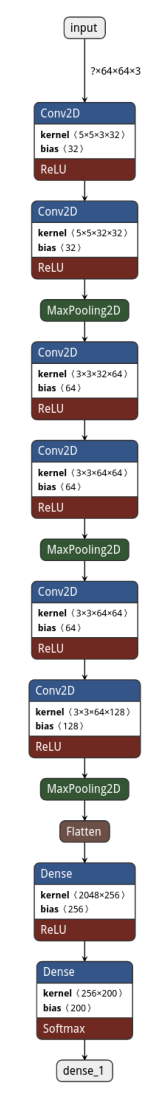

In [13]:
# TODO: Visualize the model in Netron and include an image here.
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, expand_nested=True) # Uncomment this to generate an image visualization

#My code for printing out the image created in Netron, using pyplot
plt.figure(figsize=(20, 20))
netron_image = plt.imread("netron_model.png") # Grabs saved image
plt.imshow(netron_image) # Displays the image
plt.axis('off') # Disables axis formatting in plot
plt.show() # Displays image

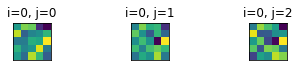

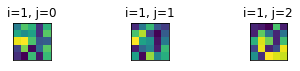

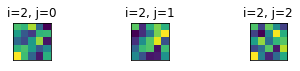

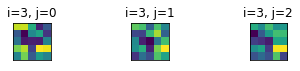

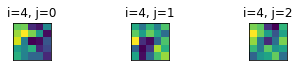

Beginning Layer: conv2d
Data Type: float32
Dimensions: 4 total (5, 5, 3, 32)
Required memory: 9600B (9.6KB)


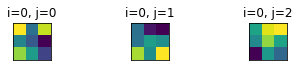

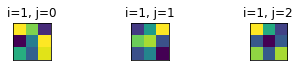

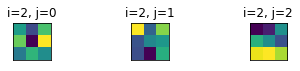

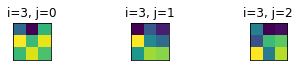

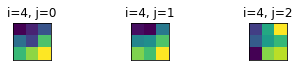

Beginning Layer: conv2d_5
Data Type: float32
Dimensions: 4 total (3, 3, 64, 128)
Required memory: 294912B (294.912KB)


In [14]:
# We can view the layer weights as well. Here we are pretending they are images
# TODO: Visualize the 2 convolutional layers filter sets (weights) (one at the beginning and one at the end)

# TODO: Your Code Here

# Begin with our beginning input layer
# beginning_layer = model.layers[3]
# filter_weight, filter_biases = beginning_layer.get_weights()

# print(f'Beginning Layer: {beginning_layer.name}') # Prove name of layer
# print(f'Data Type: {filter_weight.dtype}') # Print dtype
# print(f'Dimensions: {filter_weight.ndim} total {filter_weight.shape}') # Print #dims, + shape
# print(f'Required memory: {filter_weight.nbytes}B ({filter_weight.nbytes/1000}KB)') # Print storage amt

# filter_min, filter_max = filter_weight.min(), filter_weight.max()
# filter_weight = (filter_weight - filter_min) / (filter_max - filter_min)
# n_filters, i = 14, 1

# for foo in range(1, n_filters):
#     f = filter_weight[:, :, :, foo]
#     for j in range(3):
#         ax = plt.subplot(n_filters, 5, foo)
#         ax.set_xticks([])
#         ax.set_yticks([])

#         plt.imshow(f[:, :, j])
#         foo += 1
# plt.figure(figsize=(160, 160), dpi=10).show()

# # End with our later layer
# later_layer = model.layers[7]
# filter_weight, filter_biases = later_layer.get_weights()

# print(f'Ending Layer: {later_layer.name}') # Prove name of layer
# print(f'Data Type: {filter_weight.dtype}') # Print dtype
# print(f'Dimensions: {filter_weight.ndim} total {filter_weight.shape}') # Print #dims, + shape
# print(f'Required memory: {filter_weight.nbytes}B ({filter_weight.nbytes/1000}KB)') # Print storage amt

# filter_min, filter_max = filter_weight.min(), filter_weight.max()
# later_layer = (filter_weight - filter_min) / (filter_max - filter_min)
# n_filters, i = 22, 1

# for foo in range(1, n_filters):
#     f = filter_weight [:, :, :, foo]
#     for j in range(5):
#         ax = plt.subplot(n_filters, 5, foo)
#         ax.set_xticks([])
#         ax.set_yticks([])

#         plt.imshow(f[:, :, j])
#         foo += 1
# plt.figure(figsize=(160, 160), dpi=10).show()

filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 5, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j])
        plt.title(f'i={i}, j={j}')
        ix += 1
    plt.show()

print(f'Beginning Layer: {model.layers[0].name}') # Prove name of layer
print(f'Data Type: {filters.dtype}') # Print dtype
print(f'Dimensions: {filters.ndim} total {filters.shape}') # Print #dims, + shape
print(f'Required memory: {filters.nbytes}B ({filters.nbytes/1000}KB)') # Print storage amt

filters, biases = model.layers[7].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 5, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j])
        plt.title(f'i={i}, j={j}')
        ix += 1
    plt.show()

print(f'Beginning Layer: {model.layers[7].name}') # Prove name of layer
print(f'Data Type: {filters.dtype}') # Print dtype
print(f'Dimensions: {filters.ndim} total {filters.shape}') # Print #dims, + shape
print(f'Required memory: {filters.nbytes}B ({filters.nbytes/1000}KB)') # Print storage amt



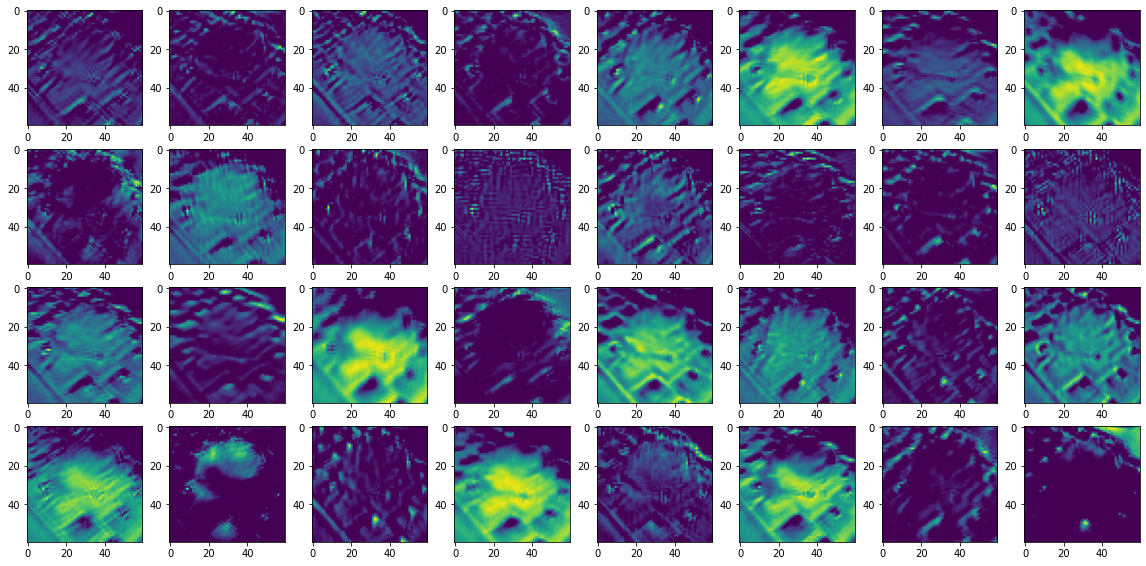

Beginning Layer: conv2d
Data Type: float32
Dimensions: 4 total (1, 60, 60, 32)
Required memory: 460800B (460.8KB)


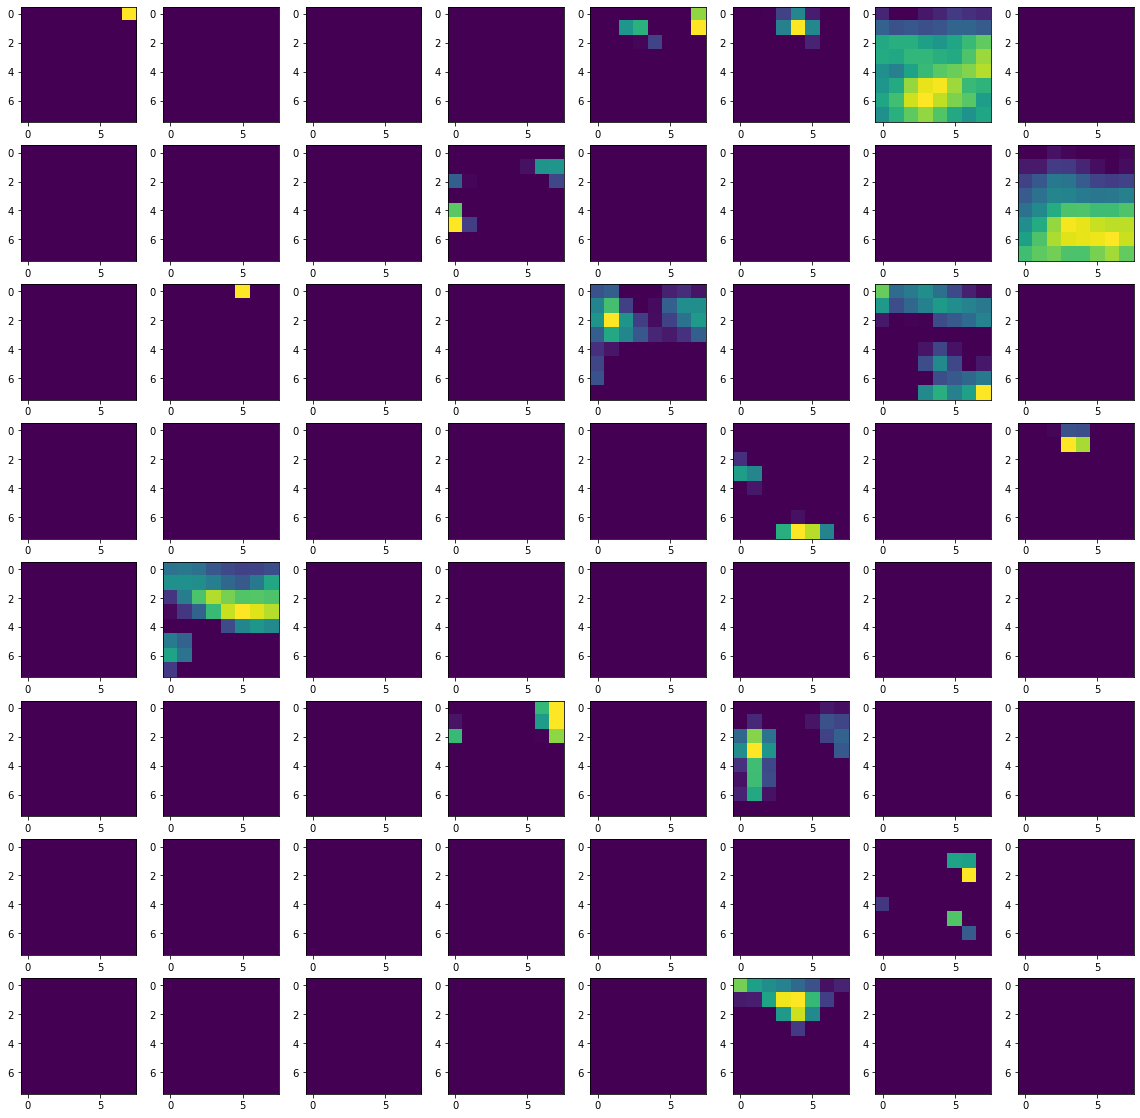

End Layer: conv2d_5
Data Type: float32
Dimensions: 4 total (1, 8, 8, 128)
Required memory: 32768B (32.768KB)


In [15]:
# We can again view the layer outputs as well. Here we are pretending they are images
# TODO: Visualize the 2 convolutional layers outputs (intermediate feature maps) (one at the beginning and one at the end


# TODO: Your Code Here
# test_model = tf.keras.applications.vgg16.VGG16()

# for i in range(len(model.layers)):
#     layer = model.layers[i]
#     if 'conv' not in layer.name:
#         continue    
#     print(i , layer.name , layer.output.shape)

# Run inference to get feature maps on earlier layer
sub_model = Model(inputs=model.inputs, outputs=model.layers[0].output)

#print(f"Printing feature maps for layer {model.layers[0].name}...")

image = sample_imgs[0]['image']
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = tf.keras.applications.vgg16.preprocess_input(image)

feature_maps = sub_model.predict(image)
idx = 1
fig = plt.figure(figsize=(20, 20))
for i in range (1, feature_maps.shape[3]+1):

    if idx == 65:
        break

    plt.subplot(8, 8, i)
    plt.imshow(feature_maps[0, :, :, i-1])
    idx += 1
    

plt.show()

print(f'Beginning Layer: {model.layers[0].name}') # Prove name of layer
print(f'Data Type: {feature_maps.dtype}') # Print dtype
print(f'Dimensions: {feature_maps.ndim} total {feature_maps.shape}') # Print #dims, + shape
print(f'Required memory: {feature_maps.nbytes}B ({feature_maps.nbytes/1000}KB)') # Print storage amt

# Run infrence to get feature maps on end conv layer

sub_model = Model(inputs=model.input, outputs=model.layers[7].output)

#print(f"Printing feature maps for layer {model.layers[7].name}...")

image = sample_imgs[0]['image']
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = tf.keras.applications.vgg16.preprocess_input(image)

feature_maps = sub_model.predict(image)

idx = 1
fig = plt.figure(figsize=(20, 20))
for i in range (1, feature_maps.shape[3]+1):

    if idx == 65:
        break

    plt.subplot(8, 8, i)
    plt.imshow(feature_maps[0, :, :, i-1])
    idx += 1

plt.show()

print(f'End Layer: {model.layers[7].name}') # Prove name of layer
print(f'Data Type: {feature_maps.dtype}') # Print dtype
print(f'Dimensions: {feature_maps.ndim} total {feature_maps.shape}') # Print #dims, + shape
print(f'Required memory: {feature_maps.nbytes}B ({feature_maps.nbytes/1000}KB)') # Print storage amt

In [16]:
# TODO: Export the filters/weights se we can use them later
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)


# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match("conv", layer.name):
        weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'conv{conv_index}_bias.bin')
        conv_index += 1
    elif re.match("dense", layer.name):
        weight_file_name = os.path.join(model_dir, f'dense{dense_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'dense{dense_index}_bias.bin')
        dense_index += 1
    else:
        continue
    # INPUT CODE BELOW
    weights, biases = layer.get_weights()
    weight_data, bias_data = weights.flatten(), biases.flatten()
    weight_file = open(weight_file_name, 'wb').write(weight_data.tobytes())
    bias_file = open(bias_file_name, 'wb').write(bias_data.tobytes())

            
print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")

All the convolution and dense (fully connected) weights and biases successfully exported to input folders in /home/tjfriedl/Desktop/cpre_487/lab1/model_data directory


In [17]:
# TODO: Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'test_input_{img_idx}')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    
    for layer_idx, layer in enumerate(model.layers):
        aux_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output])
        
        # Store the intermediate output
        
        # TODO: Your Code Here
        aux_image = tf.keras.preprocessing.image.img_to_array(img['image'])
        aux_image = np.expand_dims(aux_image, axis=0)
        aux_image = tf.keras.applications.vgg16.preprocess_input(aux_image)

        feature_maps = aux_model.predict(aux_image)

        fmap_data = feature_maps.flatten()
        fmap_file_name = os.path.join(file_dir, f'layer_output_{layer_idx}.bin')
        fmap_file = open(fmap_file_name, 'wb').write(fmap_data.tobytes())

        
print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")

All the corresponding intermediate layer outputs successfully exported to each input folder in the /home/tjfriedl/Desktop/cpre_487/lab1/img_data directory


## Tensorboard

In [18]:
# Setup for profiling
tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=1, python_tracer_level=0, device_tracer_level=1
)

log_dir = os.path.abspath(os.path.join('log_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir).mkdir(exist_ok=True, parents=True)

In [19]:
# TODO: Sample Profiling - Inference for a single image:

# Perform the inference profiling:

# THE ABOVE EXAMPLE IS DONE FOR ONLY A SINGLE TEST IMAGE FROM ds_train.batch(1).take(1)

for example in ds_train.batch(1).take(1):
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'single-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual inference
    # TODO: Your Code Here
    model.predict(example['image'])
    
 
    # Stops Profile logging
    tf.profiler.experimental.stop()

# THE BELOW EXAMPLE IS DONE FOR OUR THREE SAMPLE IMAGES COMING FROM sample_imgs
# tf.profiler.experimental.start(os.path.join(log_dir, f'single-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))
# for image in sample_imgs:
#     # Starts Profile logging
#     #tf.profiler.experimental.start(os.path.join(log_dir, f'single-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

#     #Actual inference
#     # TODO: Your Code Here
#     img = tf.keras.preprocessing.image.img_to_array(image['image'])
#     img = np.expand_dims(img, axis=0)
#     img = tf.keras.applications.vgg16.preprocess_input(img)

#     model.predict(img)

#     #  Stops Profile logging
# tf.profiler.experimental.stop()
    

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=log_dir

# You could view the tensorboard in the browser url: http://localhost:6006/

Reusing TensorBoard on port 6006 (pid 226879), started 1:40:11 ago. (Use '!kill 226879' to kill it.)

In [20]:
# TODO: Sample Profiling - Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index = [10, 100, 1000]

for idx in loop_index:
    # Starts Profile logging
    # tf.profiler.experimental.stop()
    tf.profiler.experimental.start(os.path.join(log_dir, f'online-infrence-{idx}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual online inference
    # TODO: Your Code Here
    for index, example in enumerate(ds_val.take(idx)):
        sample = tf.keras.preprocessing.image.img_to_array(example['image'])
        sample = np.expand_dims(sample, axis=0)
        sample = tf.keras.applications.vgg16.preprocess_input(sample)

        model.predict(sample)
    print(f'BATCH CALCULATION {idx} COMPLETE')


    # Stops Profile logging
    tf.profiler.experimental.stop()

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=log_dir

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.

BATCH CALCULATION 10 COMPLETE
BATCH CALCULATION 100 COMPLETE
BATCH CALCULATION 1000 COMPLETE
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 226879), started 1:40:46 ago. (Use '!kill 226879' to kill it.)

In [21]:
# TODO: Sample Profiling - Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images 
# using different batch sizes of 20, 40, 100, 200 

# Decides the size of the batch. Try: 20, 40, 100, 200
batch_size = [20, 40, 100, 200]

for batch in batch_size:
    # Starts Profile logging
    
    tf.profiler.experimental.start(os.path.join(log_dir, f'batch-{batch}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual Batch inference
    # TODO: Your Code Here        
    for example in enumerate(ds_val.batch(batch).take(1000)):
        model.predict(sample)
    print(f'BATCH SIZE {batch} COMPLETE')

    # Stops Profile logging
    tf.profiler.experimental.stop()

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=log_dir

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.


BATCH SIZE 20 COMPLETE
BATCH SIZE 40 COMPLETE
BATCH SIZE 100 COMPLETE
BATCH SIZE 200 COMPLETE
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 226879), started 1:41:27 ago. (Use '!kill 226879' to kill it.)

## Training

In [22]:
# Setup for model training
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout 

train_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=train_dir, histogram_freq=1)
]

In [23]:
# Basic CNN model
train_model = Sequential()

# conv1
train_model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
train_model.add(Conv2D(32, (5,5),activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(128, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Flatten())

# fc1
train_model.add(Dense(256, activation='relu'))

# fc2
train_model.add(Dense(200, activation='softmax'))

train_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

In [48]:
# TODO: Attempt to train your own model with different batch sizes


def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200)
    return tf.cast(image, tf.float32), tf.cast(label, tf.int64)

ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

ds_retrain = ds_retrain.cache().shuffle(1024)
ds_reval = ds_reval.cache().shuffle(1024)

ds_retrain = ds_retrain.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain = ds_retrain.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)

epoch_size = 20


for batch_size in [32, 64, 128]:
    # Setup our batched datasets
    # TODO: Your Code Here
    # train_imgset, train_lblset, val_imgset, val_lblset = [], [], [], []

    # for img_data in ds_retrain.batch(batch_size):
    #     train_imgset.append(img_data['image'])


    # reval_batch = ds_reval.batch(batch_size)

    retrain = ds_retrain.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    reval = ds_reval.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)



    # for image in retrain:
    #     train_imgset.append(image['image'])
    #     train_lblset.append(image['label'])

    # for image in reval:
    #     val_imgset.append(image['image'])
    #     val_lblset.append(image['label'])

    # train_imgset = map(lambda x: x['image'], retrain_batch)
    # train_lblset = map(lambda x: x['label'], retrain_batch)

    # for img_data, index in enumerate(retrain_batch):
    #     train_imgset.append(img_data[index]['image'])
    #     train_lblset.append(img_data[index]['label'])
    # train_imgset = retrain_batch['image']
    # train_lblset = ds_retrain['label'][...]
    # val_imgset = ds_reval['image'][...]
    # val_lblset = ds_reval['label'][...]


    
    # Run training
    # TODO: Your Code Here

    train_model.fit(x=retrain, validation_data=reval, epochs=epoch_size, batch_size=batch_size, callbacks=[callbacks])
    loss, acc = train_model.evaluate(reval['image'], reval['label'])
 
    # Save the cnn model
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    # TODO: Your Code Here

TypeError: fit() got an unexpected keyword argument 'epoch_size'

In [ ]:
# TODO: Train your model with 3 different numbers of epochs
batch_size = 32

# Setup your datasets
# TODO: Your Code Here

for epoch_size in [3, 10, 100]:
    # Run training
    # TODO: Your Code Here

    # Save the cnn model
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    # TODO: Your Code Here

## Above and Beyond

In [ ]:
# Benchmark our dataset to make sure loading our data isn't a bottleneck ... and because we can
# (This can be skipped since it can take a bit and is't all that important)

# tfds.benchmark(ds_train.batch(32), batch_size=32, num_iter=2**20)